In [1]:
import geopy.distance
import numpy as np
import pandas as pd
from random import choices

# 1. Generating data

In [2]:
nestle_coord = (46.466634011, 6.835639010)
density_coord = pd.read_csv('STATPOP2021_WGS84.csv')
distance_cutoff = 20

In [3]:
density_coord_nestle = density_coord[density_coord.apply(
    lambda row: geopy.distance.distance(
        (row.latitude, row.longitude), nestle_coord).km < distance_cutoff,
    axis=1)
].reset_index(drop=True)
total_pop = density_coord_nestle.B21BTOT.sum()
density_coord_nestle['propability_density'] = (density_coord.B21BTOT / total_pop);

density_coord_nestle.to_csv('STATPOP2021_WGS84.csv')

Draw 50 employees location from the density function around Nestle's HQ

In [41]:
n_employees = 10
n_nodes = n_employees + 1
employee_indexes = choices(density_coord_nestle.index, density_coord_nestle.propability_density, k=n_employees)
employee_locations = density_coord_nestle.iloc[employee_indexes][['latitude', 'longitude']]

# We have to account for the possibility that more than one employees live at the same location
employee_locations_grouped = employee_locations.groupby([employee_locations.index, 'latitude', 'longitude'],
                                                        as_index=False).size()

In [42]:
coordinates_list = list(zip(employee_locations.latitude.tolist(), employee_locations.longitude.tolist()))
coordinates_list = [nestle_coord] + coordinates_list

# 2. Building the distance matrix

In [43]:
import os
from dotenv import load_dotenv
import requests
import json

load_dotenv()
key = os.getenv('GCP_KEY_0X')

In [44]:
url = 'https://routes.googleapis.com/distanceMatrix/v2:computeRouteMatrix'
headers = {
    'Content-Type': 'application/json',
    'X-Goog-Api-Key': key,
    'X-Goog-FieldMask': 'originIndex,destinationIndex,duration,distanceMeters,status,condition'
}
payload = str({
    'origins': [{'waypoint': {
        'location': {
            'latLng': {
                'latitude': latitude,
                'longitude': longitude
            }
        }
    }} for latitude, longitude in coordinates_list],
    'destinations': [{'waypoint': {
        'location': {
            'latLng': {
                'latitude': latitude,
                'longitude': longitude
            }
        }
    }} for latitude, longitude in coordinates_list],
    'travelMode': 'DRIVE',
    'routingPreference': 'TRAFFIC_AWARE'
})
response = requests.request('POST', url, headers=headers, data=payload)

In [45]:
distance_matrix_time = [[0] * n_nodes for _ in range(n_nodes)]
distance_matrix_distance = [[0] * n_nodes for _ in range(n_nodes)]

for distance in response.json():
    distance_matrix_time[distance['originIndex']][distance['destinationIndex']] = int(distance['duration'][:-1])
    if distance['originIndex'] == distance['destinationIndex']:
        distance_matrix_time[distance['originIndex']][distance['destinationIndex']] = 0
    else:
        distance_matrix_distance[distance['originIndex']][distance['destinationIndex']] = distance['distanceMeters']

distance_matrix_time

[[0, 1106, 1419, 1309, 1251, 1101, 1462, 1388, 1595, 1234, 896],
 [1157, 0, 1249, 1951, 1895, 940, 1334, 976, 1453, 1067, 977],
 [1383, 1277, 0, 2205, 2143, 853, 224, 2242, 147, 354, 1790],
 [1649, 2223, 2540, 0, 212, 2158, 2619, 2433, 2707, 2339, 2197],
 [1563, 2128, 2444, 206, 0, 2084, 2527, 2323, 2595, 2209, 2122],
 [1026, 921, 847, 1839, 1779, 0, 784, 1836, 786, 649, 1433],
 [1461, 1316, 201, 2280, 2219, 792, 0, 2221, 319, 349, 1871],
 [1428, 959, 2213, 2113, 2055, 1865, 2268, 0, 2352, 1924, 1344],
 [1487, 1420, 116, 2304, 2242, 857, 307, 2352, 0, 447, 1886],
 [1196, 1021, 336, 2016, 1959, 663, 352, 1927, 477, 0, 1614],
 [866, 961, 1838, 1819, 1771, 1482, 1887, 1355, 1957, 1654, 0]]

# Solving the VRP

In [46]:
def get_solution(data, manager, routing, solution) -> dict():
    """Prints solution on console."""
    print(f'Objective: {solution.ObjectiveValue()}')

    if not solution:
        print('No solution found !')
        return {}

    max_route_distance = 0
    solution_dict = {
        'routes': [{
            'route': [],
            'routeSize': 0
        } for _ in range(data['num_vehicles'])],
        'objective': solution.ObjectiveValue()
    }

    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        plan_output = f'Route for vehicle {vehicle_id}:\n'
        route_distance = 0
        while not routing.IsEnd(index):
            plan_output += f' {manager.IndexToNode(index)} -> '
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id)

            solution_dict['routes'][vehicle_id]['route'].append(manager.IndexToNode(previous_index))
            solution_dict['routes'][vehicle_id]['routeSize'] += route_distance

        plan_output += f'{manager.IndexToNode(index)}\n'
        plan_output += f'Distance of the route: {route_distance}m\n'
        solution_dict['routes'][vehicle_id]['route'].append(manager.IndexToNode(index))
        print(plan_output)
        max_route_distance = max(route_distance, max_route_distance)
    print(f'Maximum of the route distances: {max_route_distance}s')
    return solution_dict

In [47]:
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp

data = {
    'distance_matrix': distance_matrix_time,
    'num_vehicles': 4,
    'office': 0
}

manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                       data['num_vehicles'],
                                       data['office'])

routing = pywrapcp.RoutingModel(manager)


def distance_callback(origin: int, destination: int) -> int:
    return data['distance_matrix'][manager.IndexToNode(origin)][manager.IndexToNode(destination)]


transit_callback_index = routing.RegisterTransitCallback(distance_callback)
routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

dimension_name = 'Distance'
routing.AddDimension(
    transit_callback_index,
    name=dimension_name,
    slack_max=0,  # no slack
    capacity=8000,
    fix_start_cumul_to_zero=True,
)

distance_dimension = routing.GetDimensionOrDie(dimension_name)
distance_dimension.SetGlobalSpanCostCoefficient(100)

# Setting first solution heuristic
search_parameters = pywrapcp.DefaultRoutingSearchParameters()
search_parameters.first_solution_strategy = (routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

In [48]:
# Solve the problem
solution = routing.SolveWithParameters(search_parameters)

In [49]:
current_solution = get_solution(data, manager, routing, solution)

Objective: 363792
Route for vehicle 0:
 0 ->  5 ->  10 -> 0
Distance of the route: 3400m

Route for vehicle 1:
 0 ->  7 ->  1 -> 0
Distance of the route: 3504m

Route for vehicle 2:
 0 ->  3 ->  4 -> 0
Distance of the route: 3084m

Route for vehicle 3:
 0 ->  9 ->  6 ->  8 ->  2 -> 0
Distance of the route: 3404m

Maximum of the route distances: 3504s


In [53]:
shuttle_routes = \
    [[
        f'{str(coordinates_list[current_index][0])},' \
        f'{str(coordinates_list[current_index][1])}'
    for current_index in route['route']]
        for route in current_solution['routes']]
shuttle_routes

[['46.466634011,6.83563901',
  '46.50597829392422,6.681695107444538',
  '46.51058730931472,6.852319706331602',
  '46.466634011,6.83563901'],
 ['46.466634011,6.83563901',
  '46.62523513521554,6.935944976611558',
  '46.56777895548748,6.78256846503339',
  '46.466634011,6.83563901'],
 ['46.466634011,6.83563901',
  '46.32040239580926,6.964739039052449',
  '46.31497216617444,6.956996976382114',
  '46.466634011,6.83563901'],
 ['46.466634011,6.83563901',
  '46.5398830477122,6.640805671446849',
  '46.52813413768403,6.633158627953449',
  '46.52538915467401,6.626682793471534',
  '46.52898719982704,6.626628739724092',
  '46.466634011,6.83563901']]

# 3 Visualisation of the routes

In [54]:
import numpy
import os
from dotenv import load_dotenv
import requests
from IPython.display import Image
import json
import polyline
from copy import deepcopy

load_dotenv()

True

In [55]:
list1 = ["Pl. des Anciens-Fossés 6, 1814 La Tour-de-Peilz", "Av. de l'Ile-Heureuse 23, 1800 Vevey",
         "Av. du Général-Guisan 41, 1800 Vevey", "Chem. du Petit-Centenaire 6, 1802 Corseaux"]
list2 = ["Rue d'Entre-deux-Villes 8, 1814 La Tour-de-Peilz", "Av. de Traménaz 46, 1814 La Tour-de-Peilz",
         "Rte de Blonay 94, 1814 La Tour-de-Peilz"]
list3 = ["40.737102,-73.990318", "40.749825,-73.987963", "40.752946,-73.987384", "40.755823,-73.986397"]
list4 = ["40.727102,-73.990318", "40.739825,-73.977963", "40.742946,-73.977384", "40.745823,-73.976397"]
list5 = ["Rue de la Madeleine 17, 1800 Vevey", "Rue des Moulins 17, 1800 Vevey", "Chem. Emile-Javelle 2, 1800 Vevey",
         "Rte de Saint-Légier 11, 1800 Vevey"]
list6 = ["Rue de la Madeleine 17, 1800 Vevey", "Rue du Simplon 28, 1800 Vevey", "Av. du Général-Guisan 1, 1800 Vevey"]

#shuttles = [list1,list2]

In [56]:
### Function to give a list of directions to follow to go from origin to destination
# Inputs:   origin: a string with the localisation point of the origin
#           destination: a string with the localisation point of the destination
# Output:   A list of tuple (locations) representing the path from origin to destination
colors = ["blue", "red", "green", "orange", "purple", "brown", "black"]

def get_directions(origin, destination):
    url = f'https://maps.googleapis.com/maps/api/directions/json' \
          f'?origin={origin}' \
          f'&destination={destination}' \
          f'&key={key}' \
          f'&size=1280x1280'

    response = requests.request("GET", url)
    travel_route_poly =  response.json()['routes'][0]['overview_polyline']['points']

    return polyline.decode(travel_route_poly)

In [57]:
### Funtion to create the path between all localisation points of a list
# Inputs:   list: a list of strings with location points
# Outputs:  a string with the path to follow

def fct_give_parcours(list, color):
    path = []
    start = list.pop(0)
    while list:
        path += get_directions(start, list[0])
        start = list.pop(0)
    #color = "0x"+''.join([random.choice('ABCDEF0123456789') for i in range(6)])

    travel_list = f'&path=color:{color}|weight:5|enc:{polyline.encode(path)}'

    return (travel_list)

In [77]:
### Function to create a map with the localisations and path to follow
# Inputs:   shuttles: a list of lists with strings of loaclisation points to visit
#           paths: a string with the path to follow
# Output:   A map with the localisations to visit (numbered from 0 (start)), and the path in a random color

def fct_maps(shuttles, paths):
    # Start with Nestle HQ Marker
    labels_list = "&markers=color:" + "0xCE0635" + "%7Clabel:" + str('N') + "%7C" + str(shuttle_routes[0][0])
    c = 0
    for shuttle in shuttles:
        labels_s = ""
        # We only start labelling from 1st stop to keep the 0 special.
        for i in range(len(shuttle))[1:]:
            labels_s = labels_s + "&markers=size:mid%7Ccolor:" + colors[c] + "%7Clabel:" + str(i) + "%7C" + str(shuttle[i])

        labels_list = labels_list + labels_s
        c += 1

    url = f'https://maps.googleapis.com/maps/api/staticmap' \
          f'?size=1000x1000' \
          f'{labels_list}' \
          f'{paths}' \
          f'&key={key}'

    payload = {}
    headers = {}

    response = requests.request("GET", url, headers=headers, data=payload)

    return Image(response.content)

In [78]:
### Function to run the whole algorithm
# Inputs:   shuttles: a list of lists with strings of loaclisation points to visit
#           key: the maps api key
# Output:   A map with the localisations to visit (numbered from 0 (start)), and the path in a random color

def fct_run_maps(shuttles):
    paths = ""
    c = 0

    for s in deepcopy(shuttles):
        paths = paths + fct_give_parcours(s, colors[c])
        c += 1

    return (fct_maps(shuttles, paths))

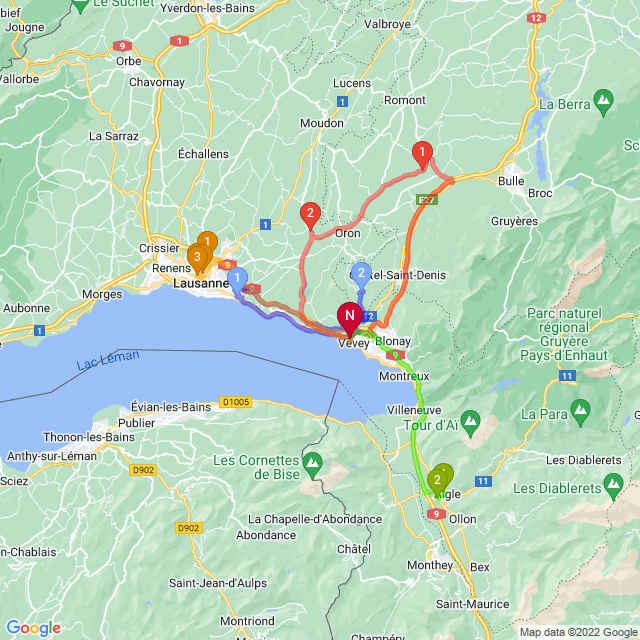

In [79]:
fct_run_maps(deepcopy(shuttle_routes))